In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import string
import re
import os
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary
import cv2
import numpy as np
import tensorflow as tf
import pickle
import random

In [ ]:
device = torch.device('cuda')

# A)

In [ ]:
if not os.path.exists('/content/drive/MyDrive/DL - HW3 Practical/flick8k_dataset'):
  !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
  !unzip Flickr8k_Dataset.zip -d '/content/drive/MyDrive/DL - HW3 Practical/flick8k_dataset'

In [ ]:
if not os.path.exists('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text'):
  !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
  !unzip Flickr8k_text.zip -d 'drive/MyDrive/DL - HW3 Practical/flick8k_text'

# B)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.token.txt', 'r') as file:
  lines = file.readlines()
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted.token.txt', 'w') as file:
  for line in lines:
      line = line.strip().lower().split('\t')
      temp = line[1]
      temp = re.sub('(^|\s).($|\s)', ' ', temp)
      temp = re.sub('(^|\s)d+($|\s)', ' ', temp)
      temp = re.sub('(^|\s)(\'s)($|\s)', ' ', temp)
      temp = re.sub('(\'s\s)', '', temp)
      temp = re.sub('[^\w\s]', '', temp)
      temp = temp.strip()
      file.writelines(line[0] + '\t' + temp + '\n')

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.lemma.token.txt', 'r') as file:
  lines = file.readlines()
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted.lemma.token.txt', 'w') as file:
  for line in lines:
      line = line.strip().lower().split('\t')
      temp = line[1]
      temp = re.sub('(^| ).($| )', ' ', temp)
      temp = re.sub('(^| )d+($| )', ' ', temp)
      temp = re.sub('(^| )(\'s)($| )', ' ', temp)
      temp = re.sub('(\'s\s)', '', temp)
      temp = re.sub('[^\w\s]', '', temp)
      temp = temp.strip()
      file.writelines(line[0] + '\t' + temp + '\n')

# C)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted.token.txt', 'r') as file:
  lines = file.readlines()
vocabulary_token = {}
for line in lines:
  line = line.split('\t')
  if len(line) > 1:
    line_words = line[1].split()
    for word in line_words:
      if word in vocabulary_token.keys():
        vocabulary_token[word] += 1
      else:
        vocabulary_token[word] = 1
vocabulary_token = dict(sorted(vocabulary_token.items(), key=(lambda item: item[1])))
removed_words = []
for word in vocabulary_token.keys():
  if vocabulary_token[word] < 10:
    removed_words.append(word)
removed_words.append('in')
removed_words.append('the')
removed_words.append('on')
removed_words.append('and')
removed_words.append('with')
removed_words.append('to')
removed_words.append('at')
removed_words.append('an')
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted.token.txt', 'r') as file:
  lines = file.readlines()
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted_and_removed.token.txt', 'w') as file:
  for line in lines:
    line = line.strip().lower().split('\t')
    if len(line) > 1:
      temp1 = line[1].split()
      temp2 = temp1.copy()
      for word in temp1:
        if word in removed_words:
          temp2.remove(word)
      temp = ' '.join(temp2)
    else:
      temp = ''
    file.writelines(line[0] + '\t' + temp + '\n')
for word in removed_words:
  del vocabulary_token[word]
print(len(vocabulary_token))

1940


In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted.lemma.token.txt', 'r') as file:
  lines = file.readlines()
vocabulary_lemma_token = {}
for line in lines:
  line = line.split('\t')
  if len(line) > 1:
    line_words = line[1].split()
    for word in line_words:
      if word in vocabulary_lemma_token.keys():
        vocabulary_lemma_token[word] += 1
      else:
        vocabulary_lemma_token[word] = 1
vocabulary_lemma_token = dict(sorted(vocabulary_lemma_token.items(), key=(lambda item: item[1])))
removed_words = []
for word in vocabulary_lemma_token.keys():
  if vocabulary_lemma_token[word] < 10:
    removed_words.append(word)
removed_words.append('in')
removed_words.append('the')
removed_words.append('on')
removed_words.append('and')
removed_words.append('with')
removed_words.append('to')
removed_words.append('at')
removed_words.append('an')
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted.lemma.token.txt', 'r') as file:
  lines = file.readlines()
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted_and_removed.lemma.token.txt', 'w') as file:
  for line in lines:
    line = line.strip().lower().split('\t')
    if len(line) > 1:
      temp1 = line[1].split()
      temp2 = temp1.copy()
      for word in temp1:
        if word in removed_words:
          temp2.remove(word)
      temp = ' '.join(temp2)
    else:
      temp = ''
    file.writelines(line[0] + '\t' + temp + '\n')
for word in removed_words:
  del vocabulary_lemma_token[word]
print(len(vocabulary_lemma_token))

1585


# D)

In [ ]:
class data_struct():
  def __init__(self, name, image):
    self.name = name
    self.image = image
    self.captions = []
    self.lemma_captions = []
    self.image_feature = None

In [ ]:
if not os.path.exists('/content/Flickr8k_Dataset.zip'):
  !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
if not os.path.exists('/content/Flicker8k_Dataset'):
  !unzip Flickr8k_Dataset.zip
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr_8k.trainImages.txt', 'r') as file:
  lines = file.readlines()
train_dataset = {}
for line in lines:
  line = line.strip()
  name = line.lower().split('.')[0]
  path = '/content/Flicker8k_Dataset/' + line
  image = plt.imread(path)
  train_dataset[name] = data_struct(name, image)
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted_and_removed.token.txt', 'r') as file:
  lines = file.readlines()
for line in lines:
  line = line.strip().split('\t')
  name = line[0].split('.')[0]
  if name in train_dataset.keys():
    if len(line) > 1:
      caption = '<START>' + ' ' + line[1] + ' ' + '<END>'
    else:
      caption = '<START>' + ' ' + '<END>'
    caption = caption.split()
    train_dataset[name].captions.append(caption)
with open('/content/drive/MyDrive/DL - HW3 Practical/flick8k_text/Flickr8k.adjusted_and_removed.lemma.token.txt', 'r') as file:
  lines = file.readlines()
for line in lines:
  line = line.strip().split('\t')
  name = line[0].split('.')[0]
  if name in train_dataset.keys():
    if len(line) > 1:
      lemma_caption = '<START>' + ' ' + line[1] + ' ' + '<END>'
    else:
      lemma_caption = '<START>' + ' ' + '<END>'
    lemma_caption = lemma_caption.split()
    train_dataset[name].lemma_captions.append(lemma_caption)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'wb') as f:
  pickle.dump(train_dataset, f)

# E)

In [ ]:
class data_struct():
  def __init__(self, name, image):
    self.name = name
    self.image = image
    self.captions = []
    self.lemma_captions = []
    self.image_feature = None

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'rb') as f:
  train_dataset = pickle.load(f)

In [ ]:
model = tf.keras.models.Sequential(name='feature_extractor')
model.add(tf.keras.applications.resnet.ResNet152(include_top=False, input_shape=(224, 224, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling'))
print(model.summary())

234708992/234698864 [==============================] - 4s 0us/step
Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
Total params: 58,370,944
Trainable params: 58,219,520
Non-trainable params: 151,424
_________________________________________________________________
None


In [ ]:
for index, name in enumerate(train_dataset.keys()):
  image = tf.keras.applications.resnet.preprocess_input(cv2.resize(train_dataset[name].image, (224, 224))[np.newaxis, ...])
  train_dataset[name].image_feature = model.predict(image)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'wb') as f:
  pickle.dump(train_dataset, f)

# F)

In [ ]:
class data_struct():
  def __init__(self, name, image):
    self.name = name
    self.image = image
    self.captions = []
    self.lemma_captions = []
    self.image_feature = None

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'rb') as f:
  train_dataset = pickle.load(f)

In [ ]:
word2idx_token = {}
idx2word_token = {}
for index, name in enumerate(vocabulary_token):
  word2idx_token[name] = index
  idx2word_token[index] = name
word2idx_token['<START>'] = index + 1
idx2word_token[index + 1] = '<START>'
word2idx_token['<END>'] = index + 2
idx2word_token[index + 2] = '<END>'
word2idx_token['<PAD>'] = index + 3
idx2word_token[index + 3] = '<PAD>'
with open('/content/drive/MyDrive/DL - HW3 Practical/word2idx_token.pkl', 'wb') as f:
  pickle.dump(word2idx_token, f)
with open('/content/drive/MyDrive/DL - HW3 Practical/idx2word_token.pkl', 'wb') as f:
  pickle.dump(idx2word_token, f)

In [ ]:
word2idx_lemma_token = {}
idx2word_lemma_token = {}
for index, name in enumerate(vocabulary_lemma_token):
  word2idx_lemma_token[name] = index
  idx2word_lemma_token[index] = name
word2idx_lemma_token['<START>'] = index + 1
idx2word_lemma_token[index + 1] = '<START>'
word2idx_lemma_token['<END>'] = index + 2
idx2word_lemma_token[index + 2] = '<END>'
word2idx_lemma_token['<PAD>'] = index + 3
idx2word_lemma_token[index + 3] = '<PAD>'
with open('/content/drive/MyDrive/DL - HW3 Practical/word2idx_lemma_token.pkl', 'wb') as f:
  pickle.dump(word2idx_lemma_token, f)
with open('/content/drive/MyDrive/DL - HW3 Practical/idx2word_lemma_token.pkl', 'wb') as f:
  pickle.dump(idx2word_lemma_token, f)

In [ ]:
maximum_length_captions = 0
for name in train_dataset.keys():
  for caption in train_dataset[name].captions:
    if maximum_length_captions < len(caption):
      maximum_length_captions = len(caption)
print(maximum_length_captions)
with open('/content/drive/MyDrive/DL - HW3 Practical/maximum_length_captions.pkl', 'wb') as f:
  pickle.dump(maximum_length_captions, f)

28


In [ ]:
maximum_length_lemma_captions = 0
for name in train_dataset.keys():
  for lemma_caption in train_dataset[name].lemma_captions:
    if maximum_length_lemma_captions < len(lemma_caption):
      maximum_length_lemma_captions = len(lemma_caption)
print(maximum_length_lemma_captions)
with open('/content/drive/MyDrive/DL - HW3 Practical/maximum_length_lemma_captions.pkl', 'wb') as f:
  pickle.dump(maximum_length_lemma_captions, f)

28


# G)

In [ ]:
class data_struct():
  def __init__(self, name, image):
    self.name = name
    self.image = image
    self.captions = []
    self.lemma_captions = []
    self.image_feature = None

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'rb') as f:
  train_dataset = pickle.load(f)

In [ ]:
for name in train_dataset.keys():
  train_dataset[name].captions = tf.keras.preprocessing.sequence.pad_sequences([caption for caption in train_dataset[name].captions], dtype=object, maxlen=maximum_length_captions, padding='post', value='<PAD>')

In [ ]:
for name in train_dataset.keys():
  train_dataset[name].lemma_captions = tf.keras.preprocessing.sequence.pad_sequences([lemma_caption for lemma_caption in train_dataset[name].lemma_captions], dtype=object, maxlen=maximum_length_lemma_captions, padding='post', value='<PAD>')

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'wb') as f:
  pickle.dump(train_dataset, f)

# H)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-01-15 20:00:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-15 20:00:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-15 20:00:17--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
def load_glove_model(filename):
  glove_model = {}
  with open(filename,'r', encoding='utf-8') as file:
    lines = file.readlines()
  for line in lines:
    line = line.split()
    word = line[0]
    embedding = np.array(line[1:], dtype=np.float64)
    glove_model[word] = embedding
  return glove_model

In [ ]:
glove = load_glove_model('/content/glove.6B.200d.txt')

In [ ]:
def get_weight_matrix(glove, vocabulary):
  vocab_size = len(vocabulary)
  mean = np.mean(np.array(list(glove.values())), axis=0)
  weight_matrix = np.zeros((vocab_size, np.array(list(glove.values())).shape[1]))
  for word, index in vocabulary.items():
    if word in glove.keys():
      weight_matrix[index] = glove[word]
    else: 
      weight_matrix[index] = mean
  weight_matrix[index-2] = np.ones((1, np.array(list(glove.values())).shape[1]))
  weight_matrix[index-1] = -np.ones((1, np.array(list(glove.values())).shape[1]))
  return weight_matrix

In [ ]:
embedding_matrix_token = get_weight_matrix(glove, word2idx_token)
with open('/content/drive/MyDrive/DL - HW3 Practical/embedding_matrix_token.pkl', 'wb') as f:
  pickle.dump(embedding_matrix_token, f)

In [ ]:
embedding_matrix_lemma_token = get_weight_matrix(glove, word2idx_lemma_token)
with open('/content/drive/MyDrive/DL - HW3 Practical/embedding_matrix_lemma_token.pkl', 'wb') as f:
  pickle.dump(embedding_matrix_lemma_token, f)

# I)

In [ ]:
class data_struct():
  def __init__(self, name, image):
    self.name = name
    self.image = image
    self.captions = []
    self.lemma_captions = []
    self.image_feature = None

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/train_dataset.pkl', 'rb') as f:
  train_dataset = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/word2idx_token.pkl', 'rb') as f:
  word2idx_token = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/word2idx_lemma_token.pkl', 'rb') as f:
  word2idx_lemma_token = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/idx2word_token.pkl', 'rb') as f:
  idx2word_token = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/idx2word_lemma_token.pkl', 'rb') as f:
  idx2word_lemma_token = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/maximum_length_captions.pkl', 'rb') as f:
  maximum_length_captions = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/maximum_length_lemma_captions.pkl', 'rb') as f:
  maximum_length_lemma_captions = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/embedding_matrix_token.pkl', 'rb') as f:
  embedding_matrix_token = pickle.load(f)
with open('/content/drive/MyDrive/DL - HW3 Practical/embedding_matrix_lemma_token.pkl', 'rb') as f:
  embedding_matrix_lemma_token = pickle.load(f)

In [ ]:
image_input_shape = 2048
hidden_layer_size = 2048
words_input_length = maximum_length_lemma_captions - 1
words_input_dimention = 200
vocabulary_size = len(word2idx_lemma_token)
output_size = 200
batch_size = 250
number_of_epochs = 5000
scale = 0.1

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, image_input_shape, hidden_layer_size, words_input_length, words_input_dimention, vocabulary_size):
    super(Model, self).__init__()
    self.lstm = torch.nn.LSTM(input_size=words_input_dimention, hidden_size=hidden_layer_size, batch_first=True)
    self.linear1 = torch.nn.Linear(hidden_layer_size, hidden_layer_size)
    self.linear2 = torch.nn.Linear(hidden_layer_size, output_size)
    self.activation = torch.nn.Tanh()
  def forward(self, x, hidden, c):
    pred, (hidden, c) = self.lstm(x, (hidden, c))
    pred = self.activation(self.linear2(self.activation(self.linear1(self.activation(self.linear1(pred))))))
    return pred, hidden, c

In [ ]:
model = Model(image_input_shape, hidden_layer_size, words_input_length, words_input_dimention, vocabulary_size)
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_func = torch.nn.L1Loss()
for epoch in range(number_of_epochs):
  random_names = random.sample(train_dataset.keys(), batch_size)
  x = np.zeros((batch_size, words_input_length, words_input_dimention))
  hidden = np.zeros((1, batch_size, image_input_shape))
  c = np.zeros((1, batch_size, image_input_shape))
  output = np.zeros((batch_size, words_input_length, output_size))
  for i in range(batch_size):
    random_caption = random.sample(range(len(train_dataset[random_names[i]].lemma_captions)), 1)
    for j in range(words_input_length):
      x[i, j, :] = scale*embedding_matrix_lemma_token[word2idx_lemma_token[train_dataset[random_names[i]].lemma_captions[random_caption[0]][j]]]
      if not train_dataset[random_names[i]].captions[random_caption[0]][j+1] == '<PAD>':
        output[i, j, :] = embedding_matrix_lemma_token[word2idx_lemma_token[train_dataset[random_names[i]].lemma_captions[random_caption[0]][j+1]]]
      else:
        output[i, j, :] = 1/len(output[i, j, :])
    c[0, i, :] = scale*train_dataset[random_names[i]].image_feature[0]
  x = torch.Tensor(x)
  x.requires_grad = True
  x = x.to(device)
  hidden = torch.Tensor(hidden)
  hidden.requires_grad = True
  hidden = hidden.to(device)
  c = torch.Tensor(c)
  c.requires_grad = True
  c = c.to(device)
  output = torch.Tensor(output)
  output.requires_grad = True
  output = output.to(device)
  optimizer.zero_grad()
  pred, hidden, c = model(x, hidden, c)
  loss = loss_func(pred, output)
  if (epoch+1)%5==0:
    print((epoch+1), loss.data.item())
  loss.backward()
  optimizer.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


5 0.04584687948226929
10 0.04955223947763443
15 0.04558243229985237
20 0.04573427885770798
25 0.04475165158510208
30 0.045131150633096695
35 0.04612693190574646
40 0.0434231199324131
45 0.04437195137143135
50 0.045592062175273895
55 0.044333819299936295
60 0.04418890178203583
65 0.04394310712814331
70 0.04449969530105591
75 0.04605275020003319
80 0.04410402104258537
85 0.046658847481012344
90 0.04505053162574768
95 0.04347209632396698
100 0.04582815244793892
105 0.04363691806793213
110 0.044400591403245926
115 0.04329366236925125
120 0.04519294947385788
125 0.044832371175289154
130 0.043586425483226776
135 0.04285111650824547
140 0.043068304657936096
145 0.04536138474941254
150 0.044773899018764496
155 0.04399769380688667
160 0.044119298458099365
165 0.04323546960949898
170 0.04533861577510834
175 0.04527981951832771
180 0.043116360902786255
185 0.044762689620256424
190 0.04536516219377518
195 0.045248810201883316
200 0.04397224634885788
205 0.04463684931397438
210 0.04415431618690491


In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/image_captioning_model.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
with open('/content/drive/MyDrive/DL - HW3 Practical/image_captioning_model.pkl', 'rb') as f:
  model = pickle.load(f)

# J)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:692: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


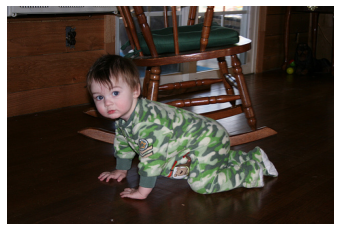

boy be sit near put


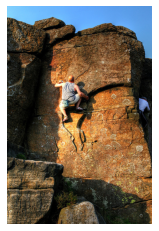

man be climb come up


In [ ]:
with torch.no_grad():
  for i in range(2):
    output = []
    random_name = random.sample(train_dataset.keys(), 1)
    hidden = np.array(scale*train_dataset[random_name[0]].image_feature[0])[np.newaxis, ...][np.newaxis, ...]
    hidden = torch.Tensor(hidden)
    hidden.requires_grad = True
    hidden = hidden.to(device)
    c = np.zeros((1, 1, image_input_shape))
    c = torch.Tensor(c)
    c.requires_grad = True
    c = c.to(device)
    x = scale*embedding_matrix_lemma_token[word2idx_lemma_token['<START>']][np.newaxis, ...][np.newaxis, ...]
    for i in range(5):
      x = torch.Tensor(x)
      x.requires_grad = True
      x = x.to(device)
      optimizer.zero_grad()
      pred, hidden, c = model(x, hidden, c)
      pred = pred.cpu().detach().numpy()[0][0]
      pred = np.argmin(np.mean(abs(embedding_matrix_lemma_token - pred), axis=1))
      output.append(idx2word_lemma_token[pred])
      if idx2word_lemma_token[pred] == '<END>':
        break
      else:
        x = scale*embedding_matrix_lemma_token[pred][np.newaxis, ...][np.newaxis, ...]
    output = ' '.join(output)
    plt.figure()
    plt.imshow(train_dataset[random_name[0]].image)
    plt.axis('off')
    plt.show()
    print(output)